In [1]:
import matplotlib.pyplot as plt
import pickle
import dill
import numpy as np

In [2]:
def load_data(path):
    #speeds are logged every simulation step (1 second), 
    #for each sim step we store a list 
    #with the speeds of all the vehicles in the sim
    with open(path + "speeds.pickle", "rb") as f:
        speeds = pickle.load(f) 
        speeds = [list(map(float, x)) for x in speeds]
    #stops are logged every sim step
    #we store the total number of stops in that sim step 
    with open(path + "stops.pickle", "rb") as f:
        stops = pickle.load(f)

    #density and flow are logged every sim step
    #we store a list with the density and flow value 
    #for each lane of the intersection 
    with open(path + "mfd.pickle", "rb") as f:
        mfd_data = pickle.load(f)
        densities = [x[0] for x in mfd_data]
        flows = [x[1] for x in mfd_data]             


    #figure out what we need with the below 
    with open(path + "agents_rewards.pickle", "rb") as f:
        pressure = pickle.load(f)
    with open(path + "waiting_time.pickle", "rb") as f:
        waiting_times = pickle.load(f)

    return speeds, stops, densities, flows, pressure, waiting_times

In [3]:
def draw_time_plot(time_series):
    plt.plot(time_series)
    plt.show()
    
def draw_time_errorbar(time_series, errors):
    plt.errorbar(range(len(time_series)), time_series, yerr=errors)
    plt.show()

def draw_mfd(density, flow):
    plt.scatter(density, flow, s=2, c='tab:cyan')
    plt.show()
    
    
def load_from_many_paths(paths):
    speeds_list, stops_list, densities_list, flows_list, pressure_list, waiting_times_list = [],[],[],[],[],[]
    for path in paths:
        speeds, stops, densities, flows, pressure, waiting_times = load_data(path)
        mean_speeds = [np.mean(x) for x in speeds]
        speeds_list.append(mean_speeds)
        stops_list.append(stops)
        mean_flows = [np.mean(x) for x in flows]
        mean_densities = [np.mean(x) for x in densities]
        densities_list.append(mean_densities)
        flows_list.append(mean_flows)
        pressure_list.append(pressure)
        waiting_times_list.append(waiting_times)
        
    return speeds_list, stops_list, densities_list, flows_list, pressure_list, waiting_times_list
        
def draw_figure(paths, names, lists=[], std_lists=[], errors = []):
    if paths != []:
        speeds_list, _, densities_list, flows_list, _, _ = load_from_many_paths(paths)   
    elif lists != []:
        speeds_list = [x[0] for x in lists]
        densities_list = [x[1] for x in lists]
        flows_list = [x[2] for x in lists]
    if errors != []:
        speeds_std = [x[0] for x in errors]
        densities_std = [x[1] for x in errors]
        flows_std = [x[2] for x in errors]
        
    fig, axs = plt.subplots(len(names), 4, figsize=(12,3*len(names)), constrained_layout=True)
    for i, (speeds, density, flow, speed_std, density_std, flow_std, 
            name) in enumerate(zip(speeds_list, densities_list, 
                                   flows_list, speeds_std, densities_std, flows_std, names)):
        if errors != []:
            axs[i, 0].errorbar(range(len(speeds)), speeds, yerr=speed_std, ecolor='cyan')
            axs[i, 1].errorbar(range(len(flow)), flow, yerr=flow_std, ecolor='cyan')
            axs[i, 2].errorbar(range(len(density)), density, yerr=density_std, ecolor='cyan')
        else:
            axs[i, 0].plot(speed)
            axs[i, 1].plot(flow)
            axs[i, 2].plot(density)
        
        axs[i, 3].scatter(density, flow, s=2)
    
        axs[i, 0].set_title(name)
        axs[i, 0].set(ylabel='Avg. Speed(m/s)')
        axs[i, 0].set(xlabel='Time(s)')
        axs[i, 1].set(ylabel='Avg. Flow(veh/s)')
        axs[i, 1].set(xlabel='Time(s)')
        axs[i, 2].set(ylabel='Avg. Density(veh/m)')
        axs[i, 2].set(xlabel='Time(s)')
        axs[i, 3].set(xlabel='Avg. Density(veh/m)')
        axs[i, 3].set(ylabel='Avg. Flow(veh/s)')

    plt.show()

%matplotlib inline

In [4]:
def load_aggregate_scenario(path, num_runs, agent_type):

    agg_speeds = []
    agg_densities = []
    agg_flows = []

    for i in range(num_runs):
        result_path = path + 'scenarios_config' + str(i) + "_" + agent_type + "/"
        speeds, stops, densities, flows, pressure, waiting_times = load_data(result_path)

        #HERE WE AVERAGE THE SPEEDS, FLOWS AND DENSITIES OVER THE ENTIRE SYSTEM
        #THUS WE GET A SINGLE VALUE OF EACH METRIC PER TIME UNIT
        mean_speeds = [np.mean(x) for x in speeds]
        mean_flows = [np.mean(x) for x in flows]
        mean_densities = [np.mean(x) for x in densities]

        agg_speeds.append(mean_speeds)
        agg_densities.append(mean_densities)
        agg_flows.append(mean_flows)
        
    return agg_speeds, agg_densities, agg_flows
    

In [5]:
def aggregate_data(scenarios_data, names):
    mean_data, std_data = [], []
    stable_avgs, stable_stds = {}, {}
    for data, name in zip(scenarios_data, names):
        agg_speeds, agg_densities, agg_flows = data

        #HERE WE AVERAGE THE METRICS OVER ALL THE RUNS OF THE SIMULATION
        mean_speeds = [np.mean(x) for x in zip(*agg_speeds)]
        std_speeds = [np.std(x) for x in zip(*agg_speeds)]

        mean_flows = [np.mean(x) for x in zip(*agg_flows)]
        std_flows = [np.std(x) for x in zip(*agg_flows)]

        mean_densities = [np.mean(x) for x in zip(*agg_densities)]
        std_densities = [np.std(x) for x in zip(*agg_densities)]

        stable_avgs[name] = {'speed' : np.mean(mean_speeds[500:-1]),'flow' : np.mean(mean_flows[500:-1]),
                                       'density' : np.mean(mean_densities[500:-1])}
        stable_stds[name] = {'speed' : np.std(mean_speeds[500:-1]), 'flow' : np.std(mean_flows[500:-1]),
                                        'density' : np.std(mean_densities[500:-1])}

        mean_data.append((mean_speeds, mean_densities, mean_flows))
        std_data.append((std_speeds, std_densities, std_flows))
    
    return mean_data, std_data, stable_avgs, stable_stds

In [6]:
paths = ['random_1x1sphere/exp_30veh/results/', 'random_1x1sphere/exp_60veh/results/', 
         'random_1x1sphere/exp_90veh/results/', 
         'random_1x1sphere/exp_120veh/results/', 'random_1x1sphere/exp_180veh/results/']
num_runs = 100
agent_type = 'random'

scenarios_data = []

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))

/Users/mkorecki/miniconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mkorecki/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


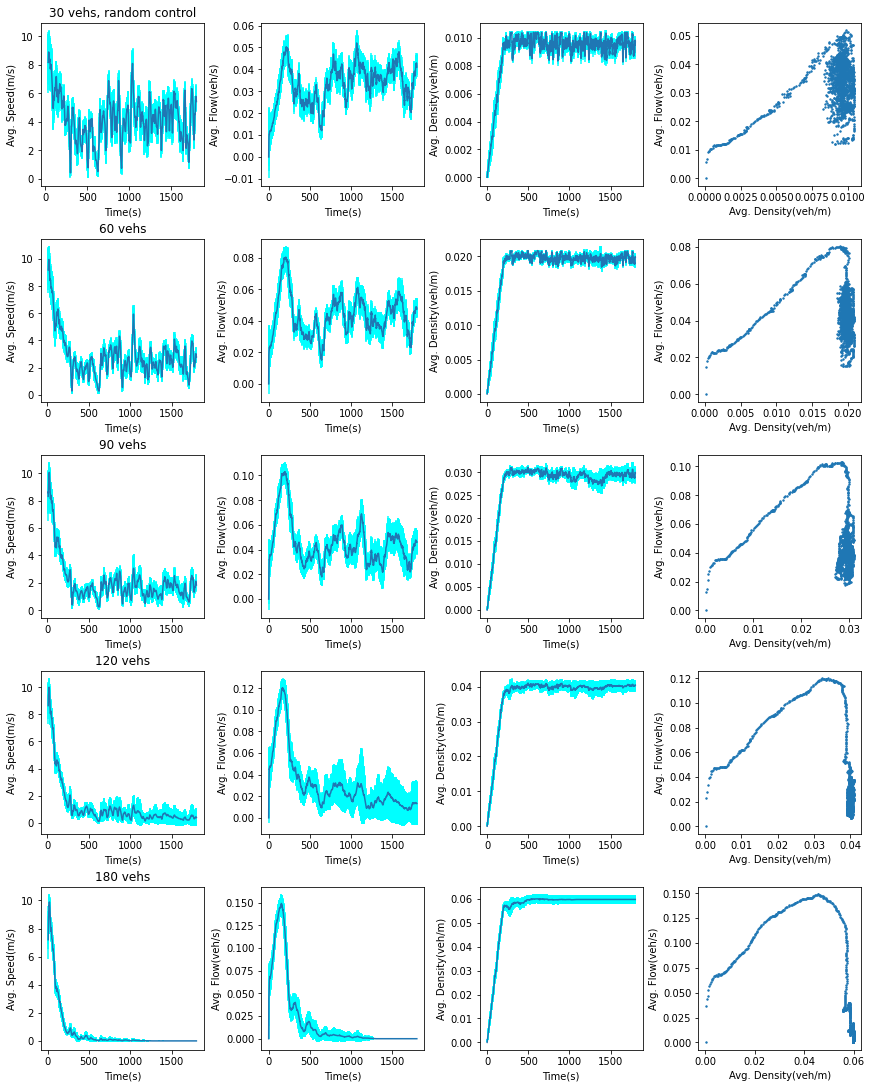

In [7]:
names = ['30', '60', '90', '120', '180']
mean_data, std_data, stable_avgs_analytical, stable_stds_analytical = aggregate_data(scenarios_data, names)
draw_figure([], ['30 vehs, random control', '60 vehs', '90 vehs', '120 vehs', '180 vehs'], lists=mean_data, errors=std_data)


In [8]:
paths = ['fixed_1x1sphere/exp_30veh/results/', 'fixed_1x1sphere/exp_60veh/results/', 
         'fixed_1x1sphere/exp_90veh/results/', 
         'fixed_1x1sphere/exp_120veh/results/', 'fixed_1x1sphere/exp_180veh/results/']
num_runs = 100
agent_type = 'fixed'

scenarios_data = []

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))

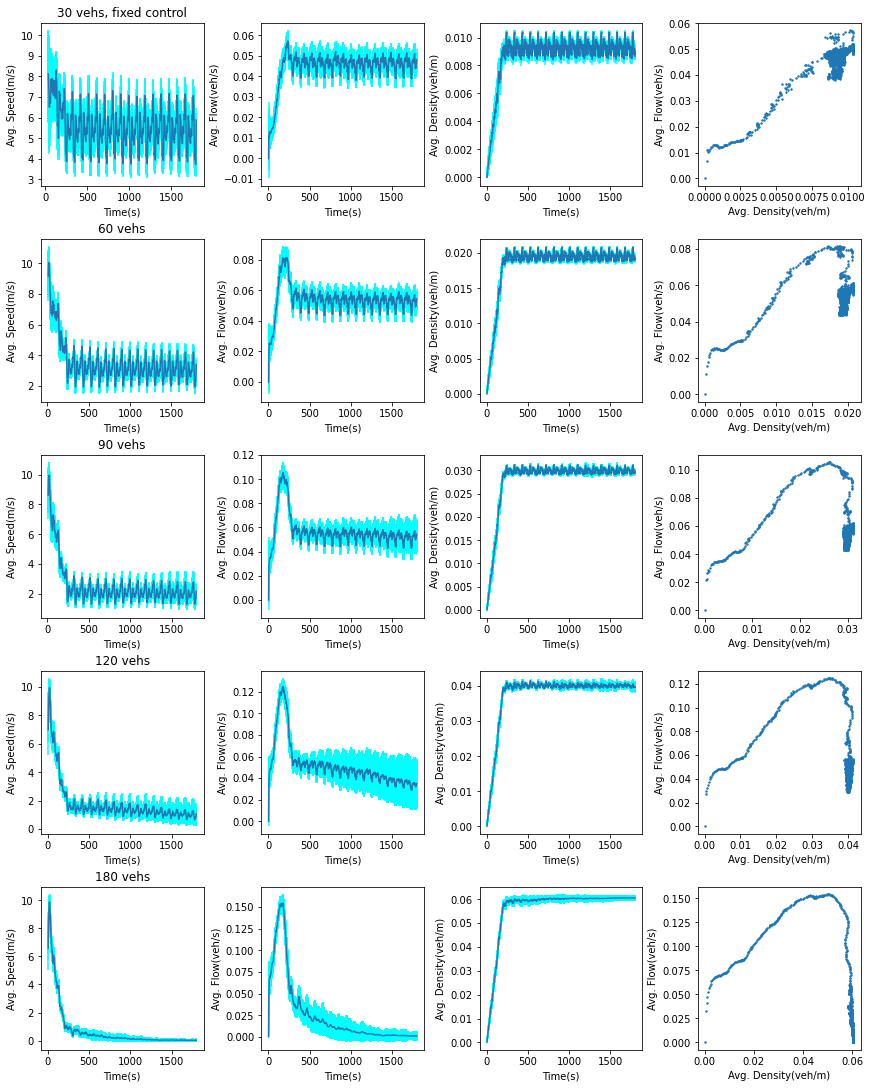

In [9]:
names = ['30', '60', '90', '120', '180']
mean_data, std_data, stable_avgs_analytical, stable_stds_analytical = aggregate_data(scenarios_data, names)
draw_figure([], ['30 vehs, fixed control', '60 vehs', '90 vehs', '120 vehs', '180 vehs'], lists=mean_data, errors=std_data)


In [10]:
paths = ['analytical_1x1sphere/exp_30veh/results/', 'analytical_1x1sphere/exp_60veh/results/', 
         'analytical_1x1sphere/exp_90veh/results/', 
         'analytical_1x1sphere/exp_120veh/results/', 'analytical_1x1sphere/exp_180veh/results/']
num_runs = 100
agent_type = 'analytical'

scenarios_data = []

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))

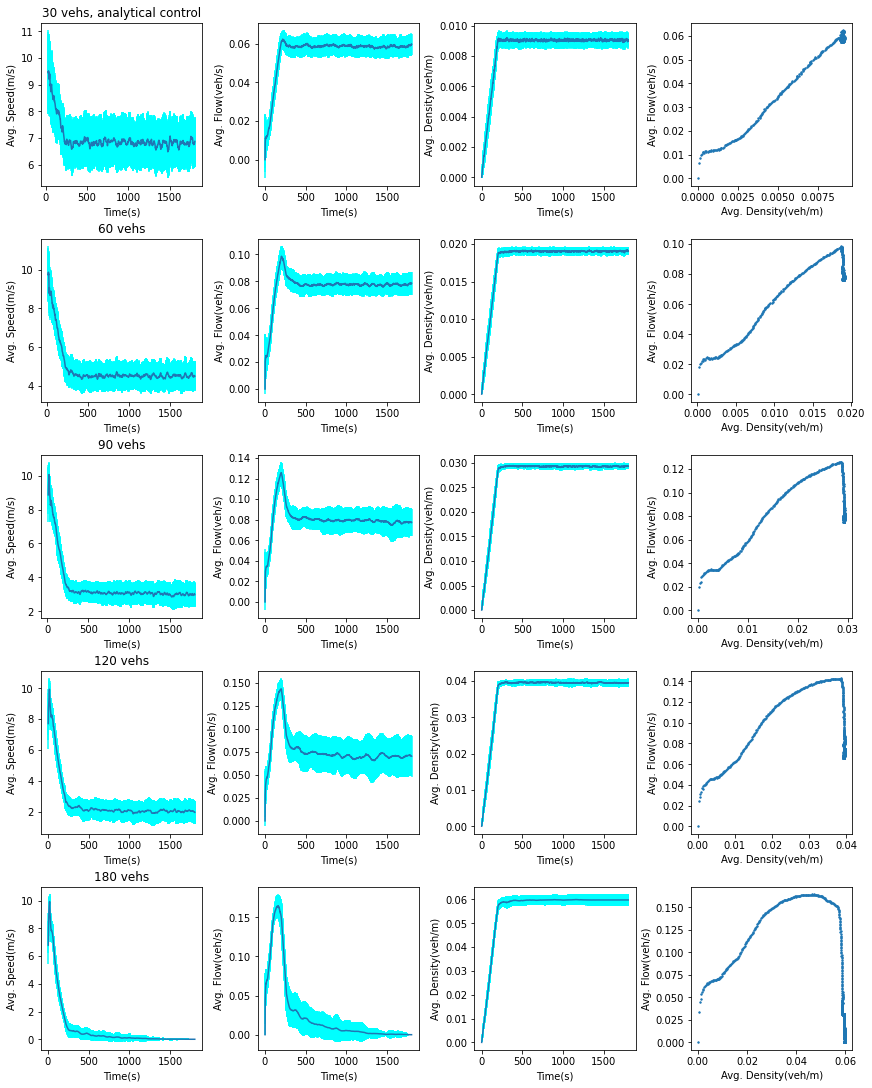

In [11]:
names = ['30', '60', '90', '120', '180']
mean_data, std_data, stable_avgs_analytical, stable_stds_analytical = aggregate_data(scenarios_data, names)
draw_figure([], ['30 vehs, analytical control', '60 vehs', '90 vehs', '120 vehs', '180 vehs'], lists=mean_data, errors=std_data)


NameError: name 'stable_avgs_random' is not defined

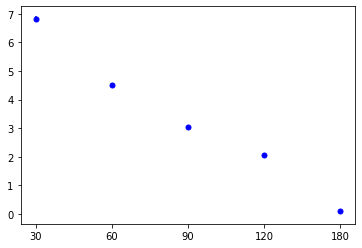

In [12]:
names = ['30', '60', '90', '120', '180']

metrics = ['speed', 'flow', 'density']


# stable_avgs_analytical['speed']
# stable_stds_analytical['speed']

colors = ['blue', 'red', 'green']

for metric in metrics:
    plt.errorbar(names, [stable_avgs_analytical[x][metric] for x in names], 
             yerr=[stable_stds_analytical[x][metric] for x in names], c='blue', 
                 ls='none', marker='o', ms=5, label='analytic')
    plt.errorbar(names, [stable_avgs_random[x][metric] for x in names],
            yerr=[stable_stds_random[x][metric] for x in names], c='black', 
                 ls='none', marker='o', ms=5, label='random')
    plt.errorbar(names, [stable_avgs_fixed[x][metric] for x in names],
            yerr=[stable_stds_fixed[x][metric] for x in names], c='red', 
                 ls='none', marker='o', ms=5, label='fixed')
    
    plt.legend()
    plt.title(metric + " average from episode 500 to 1800")
    plt.xlabel('number of vehicles')
    plt.show()

# for name, color in zip(names, colors):
#     plt.scatter(name, stable_avgs_fixed[name]['speed'], c=color)
#     plt.scatter(name, stable_avgs_random[name]['speed'], c=color)


In [ ]:
scenarios_data = []

paths = ['hybrid_1x2sphere_30veh/results/']
num_runs = 100
agent_type = 'hybrid_load'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    
paths = ['analytical_1x2sphere_30veh/results/']
agent_type = 'analytical'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
        
paths = ['fixed_1x2sphere_30veh/results/']
agent_type = 'fixed'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    
paths = ['random_1x2sphere_30veh/results/']
agent_type = 'random'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
              


In [ ]:
names = ['hybrid', 'analytical', 'fixed', 'random']
mean_data, std_data, stable_avgs_analytical, stable_stds_analytical = aggregate_data(scenarios_data, names)
draw_figure([], ['30 vehs, hybrid', 'analytical', 'fixed', 'random'], lists=mean_data, errors=std_data)


In [ ]:
scenarios_data = []

paths = ['open1x1_hybrid_3000/results/']
num_runs = 100
agent_type = 'hybrid_load'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    
paths = ['open1x1_analytic_3000/results/']
agent_type = 'analytical'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
        
paths = ['open1x1_fixed_3000/results/']
agent_type = 'fixed'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    
 

In [ ]:
names = ['hybrid', 'analytical', 'fixed']
mean_data, std_data, stable_avgs_analytical, stable_stds_analytical = aggregate_data(scenarios_data, names)
draw_figure([], ['3000 vehs, hybrid', 'analytical', 'fixed'], lists=mean_data, errors=std_data)


In [ ]:
scenarios_data = []
num_runs = 100

paths = ['open1x1_analytic_2000/results/']
agent_type = 'analytical'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    
paths = ['open1x1_hybrid_meta_train_2000/results/']
agent_type = 'hybrid_load'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    
paths = ['open1x1_hybrid_fixed_train_2000/results/']
agent_type = 'hybrid_load'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    


In [ ]:
names = ['analytical', 'hybrid', 'hybrid']
mean_data, std_data, stable_avgs_analytical, stable_stds_analytical = aggregate_data(scenarios_data, names)
draw_figure([], ['2000 vehs, analytical', 'hybrid_many_train_scenarios', 'hybrid_fixed'], lists=mean_data, errors=std_data)


In [ ]:
scenarios_data = []
num_runs = 100

paths = ['4x4_hybrid_3000/results/']
agent_type = 'hybrid_load'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
    
paths = ['4x4_hybrid_fixed_working_3000/results/']
agent_type = 'hybrid_load'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
          
paths = ['4x4_hybrid_meta_working_3000/results/']
agent_type = 'hybrid_load'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
                      
        
paths = ['4x4_analytical_3000/results/']
agent_type = 'analytical'

for path in paths:
    agg_speeds, agg_densities, agg_flows = load_aggregate_scenario(path, num_runs, agent_type)
    scenarios_data.append((agg_speeds, agg_densities, agg_flows))
   

In [ ]:
names = ['hybrid', 'hybrid', 'hybrid', 'analytical']
mean_data, std_data, stable_avgs_analytical, stable_stds_analytical = aggregate_data(scenarios_data, names)
draw_figure([], ['3000 vehs, hybrid fixed', 'hybrid_new', 'hybrid_meta', 'analytical'], lists=mean_data, errors=std_data)
